In [14]:
import hu_core_news_lg
import matplotlib.pyplot as plt
import pandas as pd
import spacy
import os
from tqdm import tqdm

In [15]:
try:
    nlp = spacy.load("hu_core_news_lg")
except:
    print("A nagy modell nem található, a közepeset használjuk...")
    nlp = spacy.load("hu_core_news_md")

In [16]:
nlp = hu_core_news_lg.load()

In [17]:
RAW_CSV = r"../../data/propaganda_articles.csv"      # A nyers, eredeti fájl
PROCESSED_CSV = r"../../data/preprocessed_data.csv"

In [18]:
csv_file = r"../../data/propaganda_articles.csv"

df = pd.read_csv(csv_file, encoding="utf-8-sig")

In [19]:
def spacy_preprocess_pipe(texts, batch_size=50):
    """
    Gyorsabb verzió nlp.pipe használatával és tqdm folyamatjelzővel.
    """
    cleaned_texts = []
    
    # Itt a lényeg: a tqdm-be csomagoljuk az nlp.pipe-ot.
    # A 'total=len(texts)' fontos, hogy tudja, mennyi a 100%.
    for doc in tqdm(nlp.pipe(texts, batch_size=batch_size, disable=["ner", "parser"]), 
                    total=len(texts), 
                    desc="Szöveg előkészítése"):
        
        tokens = []
        for token in doc:
            if token.is_stop or token.is_punct:
                continue
            if token.like_num:
                tokens.append("NUM")
            else:
                tokens.append(token.lemma_)
        
        cleaned_texts.append(" ".join(tokens))
    
    return cleaned_texts

In [20]:
def get_training_data():
    # 1. Betöltjük a nyers adatokat
    if not os.path.exists(RAW_CSV):
        raise FileNotFoundError(f"Nincs meg a forrásfájl: {RAW_CSV}")
        
    df_raw = pd.read_csv(RAW_CSV, encoding="utf-8-sig")
    df_raw = df_raw.dropna(subset=['title', 'text', 'url'])
    
    # 2. Megnézzük, van-e már mentett fájl
    if os.path.exists(PROCESSED_CSV):
        df_processed = pd.read_csv(PROCESSED_CSV, encoding="utf-8-sig")
        processed_urls = set(df_processed['url'])
        print(f"Betöltve {len(df_processed)} már feldolgozott cikk.")
    else:
        df_processed = pd.DataFrame(columns=['url', 'cleaned_text', 'label'])
        processed_urls = set()
        print("Még nincs feldolgozott fájl.")

    # 3. Kiszűrjük az újakat
    df_new = df_raw[~df_raw['url'].isin(processed_urls)].copy()

    if df_new.empty:
        print("Nincs új feldolgozandó cikk! A cache-ből dolgozunk.")
    else:
        print(f"Feldolgozás alatt: {len(df_new)} új cikk...")
        
        df_new['full_text'] = df_new['title'] + ": " + df_new['text']
        
        # --- ITT HÍVJUK MEG A TQDM-ES FÜGGVÉNYT ---
        df_new['cleaned_text'] = spacy_preprocess_pipe(df_new['full_text'].tolist())
        
        # 4. Mentés
        df_to_save = df_new[['url', 'cleaned_text', 'label']]
        header_needed = not os.path.exists(PROCESSED_CSV)
        
        df_to_save.to_csv(PROCESSED_CSV, mode='a', index=False, header=header_needed, encoding='utf-8-sig')
        
        # Összefűzés a memóriában
        df_processed = pd.concat([df_processed, df_to_save], ignore_index=True)
        print("Új adatok elmentve.")

    return df_processed['cleaned_text'], df_processed['label']

In [21]:
x, y = get_training_data()
y = y.astype(int)
x.sample()

Betöltve 1317 már feldolgozott cikk.
Nincs új feldolgozandó cikk! A cache-ből dolgozunk.


686    politikai termék sorskérdés uniós jövő tét Vál...
Name: cleaned_text, dtype: object

# TfIdf

In [22]:
hu_stop_words = [
    "2010", "2020", "a", "abban", "ad", "adatvédelmi nyilatkozat", "ahhoz", "ahogy", 
    "ahol", "ahogy", "aki", "akik", "akit", "akár", "akkor", "alá", "alatt", "által", 
    "általában", "amely", "amelyek", "amelyekben", "amelyeket", "amelyet", "amelynek", 
    "ami", "amíg", "amikor", "amit", "amolyan", "amúgy", "annak", "arra", "arról", 
    "át", "az", "azért", "azok", "azoknak", "azon", "azonban", "azt", "aztán", 
    "azután", "azzal", "ászf", "bár", "be", "bele", "belül", "benne", "cikk", 
    "cikkek", "cikkeket", "com", "copyright", "csak", "de", "e", "ebben", "eddig", 
    "egész", "egy", "egyéb", "egyes", "egyetlen", "egyik", "egyre", "ehhez", "ekkor", 
    "el", "elég", "ellen", "elő", "először", "előtt", "első", "ember", "emilyen", 
    "én", "ennek", "éppen", "erre", "es", "esetleg", "és", "evvel", "ez", "ezek", 
    "ezen", "ezért", "ezt", "ezzel", "fel", "feladva", "felé", "felett", "fel", 
    "főleg", "ha", "hanem", "hát", "hello", "helló", "helyett", "hirtelen", 
    "hiszen", "hogy", "hogyan", "hol", "hozzászólás", "hozzászólások", "http", 
    "ide", "igen", "így", "igy", "ill", "ill.", "illetve", "ilyen", "ilyenkor", 
    "impresszum", "is", "ismét", "ison", "itt", "jó", "jobban", "jog fenntartva", 
    "jogi nyilatkozat", "jól", "kategória", "kell", "kellett", "keressünk", 
    "keresztül", "ki", "kis", "kívül", "komment", "köszönöm", "köszönjük", "köszi", 
    "közepette", "között", "közül", "külön", "le", "legalább", "legyen", "lehet", 
    "lehetett", "lenne", "lenni", "lesz", "lett", "maga", "magam", "magatokat", 
    "magát", "magunk", "magunkat", "magunkkal", "magunkra", "majd", "már", "más", 
    "másik", "meg", "még", "mellett", "mely", "melyek", "mert", "mi", "miért", 
    "míg", "mikor", "milyen", "mind", "minden", "mindenki", "mindenkinek", 
    "mindenkit", "mindent", "mindig", "mindneki", "mint", "mintha", "mit", 
    "mivel", "most", "nagy", "nagyobb", "nagyon", "ne", "néha", "néhány", 
    "nekem", "neki", "nélkül", "nem", "nincs", "ő", "oda", "ők", "õk", "őket", 
    "oka", "olyan", "ön", "os", "össze", "ott", "pedig", "persze", "pici", 
    "picivel", "pont", "rá", "rám", "rajtam", "ripost", "rólam", "rólunk", "rss", 
    "s", "saját", "sajnos", "sem", "semmi", "soha", "sok", "sokat", "sokkal", 
    "száma", "számára", "szemben", "szerint", "szerintem", "szeretettel", 
    "szerző", "szét", "szia", "sziasztok", "szinte", "szó", "talán", "te", 
    "tehát", "teljes", "ti", "több", "tőle", "tőlem", "tőletek", "tőlük", 
    "tőlünk", "tovább", "továbbá", "üdv", "úgy", "ugyanis", "új", "újabb", 
    "újra", "után", "utána", "utolsó", "vagy", "vagyis", "vagyok", "valaki", 
    "valami", "valamint", "valamit", "valaminek", "valamiért", "való", "van", 
    "vannak", "vele", "velem", "veletek", "velük", "vissza", "viszont", "volna", 
    "volt", "voltak", "voltam", "voltunk", "www"
]

In [23]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
vectorizer = CountVectorizer(ngram_range=(1,2), token_pattern=r'\b\w+\b', min_df=1, max_df=0.9, max_features=2000, stop_words=hu_stop_words)
x_counts = vectorizer.fit_transform(x)

C:\Users\Levi\Documents\PyCharm Projects\propaganda\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:411: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['adatvédelmi', 'fenntartva', 'jog', 'jogi', 'nyilatkozat'] not in stop_words.
  warnings.warn(


# PCA

In [24]:
from sklearn.decomposition import  PCA
pca = PCA(n_components=2, random_state=42)
x_2d = pca.fit_transform(x_counts)

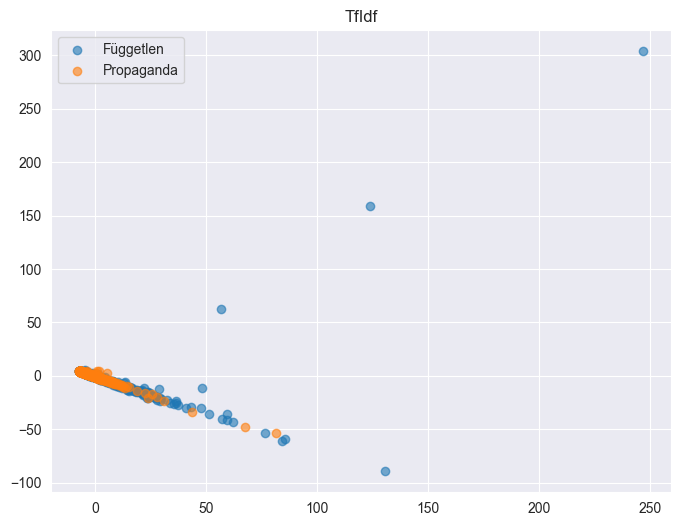

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(x_2d[y == 0, 0], x_2d[y == 0, 1], label = "Független", alpha = 0.6)
plt.scatter(x_2d[y == 1, 0], x_2d[y == 1, 1], label = "Propaganda", alpha = 0.6)
plt.legend()
plt.title("TfIdf")
plt.show()

# K-means

In [27]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(x_2d)

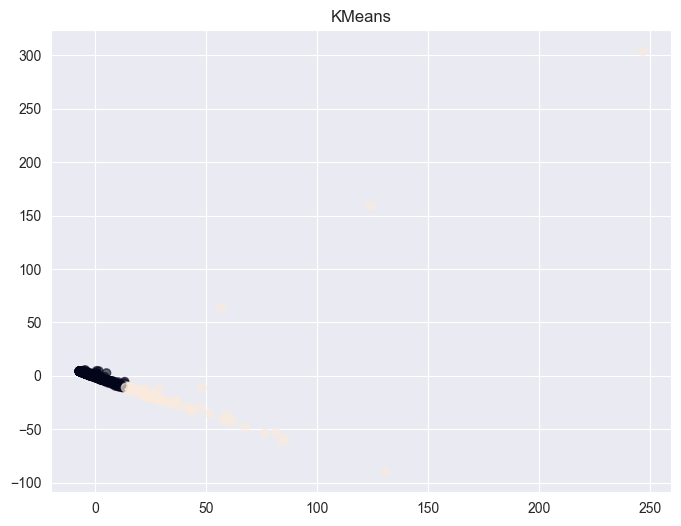

In [29]:
plt.figure(figsize=(8, 6))
plt.scatter(x_2d[:, 0], x_2d[:, 1], c=clusters, alpha=0.6)
plt.title("KMeans")
plt.show()

In [30]:
from sklearn.metrics import  adjusted_rand_score
ari = adjusted_rand_score(y, clusters)
ari

-0.007181562655767757